In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *
# CONFIG.WORK_FOLDER = ("July5/RefactoringExperiments" + path_postfix_samplings, path_postfix_tf)

In [3]:
d_truth = upload_JournalEntriesTruth("Simulation/FSN_Data_v2.db")

## Upload data

In [2]:
DB_PATH = "Simulation/FSN_Data.db"
d = upload_data(DB_PATH, limit=None)
d = prepare_data(d)

Final shape of DataFrame is  (58559, 9)


In [7]:
def countNext(df):
    c=df.groupby("Next").count()
    return pd.Series(dict(zip(list(c.T), c.T.values[0])))

In [5]:
CONFIG.WINDOW_SIZE = 3
# CONFIG.PRESSURE = 10
# CONFIG.WALKS_PER_NODE = 10
# CONFIG.WALKS_LENGTH = 10
CONFIG.HACK = 0.5
print(f"Current config parameters: \n WALKS_PER_NODE={CONFIG.WALKS_PER_NODE}, \n walk_length={CONFIG.WALKS_LENGTH}")
print(f"PRESSURE={CONFIG.PRESSURE} \n WINDOW_SIZE={CONFIG.WINDOW_SIZE}")
cur_pairs = get_SkipGrams(d, walks_per_node=CONFIG.WALKS_PER_NODE, \
                          walk_length=CONFIG.WALKS_LENGTH, use_cache=False)
print(len(cur_pairs))

Current config parameters: 
 WALKS_PER_NODE=20, 
 walk_length=8
PRESSURE=30 
 WINDOW_SIZE=3
Start sampling... wait...
--------- Started the SAMPLING the sequences from FSN ---------



Additionally sample the nearest neighbours...



Elapsed time for sampling:  3.7446630001068115
Cashing sampled sequences...


AttributeError: module 'NetEmbs.CONFIG' has no attribute 'WORK_FOLDER'

In [9]:
map_truth = dict(zip(d_truth.ID.values, d_truth.GroundTruth.values))
cur_truth = pd.DataFrame(data=[[map_truth[pair[0]], map_truth[pair[1]]] for pair in cur_pairs], columns=["Current", "Next"])
final_df = cur_truth.groupby("Current").apply(countNext).reset_index()\
        .pivot(index='Current', columns='level_1', values=0).fillna(0)
del final_df.index.name
del final_df.columns.name
final_df

,Collections,Depreciation,Disbursement,Fixed Assets,Good delivery,Payroll,Payroll Disbursement,Purchase,Sales 21 btw,Sales 6 btw,Sales tax
Collections,46844.0,0.0,6527.0,2356.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Depreciation,0.0,14204.0,0.0,4.0,23.0,11.0,0.0,1.0,9.0,10.0,0.0
Disbursement,6527.0,0.0,9156.0,8481.0,2.0,0.0,0.0,0.0,1.0,4.0,0.0
Fixed Assets,2356.0,4.0,8481.0,9414.0,14.0,1.0,0.0,0.0,8.0,26.0,0.0
Good delivery,0.0,23.0,2.0,14.0,82022.0,87.0,0.0,1.0,10.0,57.0,0.0
Payroll,0.0,11.0,0.0,1.0,87.0,38872.0,0.0,1.0,1703.0,339.0,0.0
Payroll Disbursement,0.0,0.0,0.0,0.0,0.0,0.0,6014.0,0.0,0.0,0.0,11092.0
Purchase,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1390.0,0.0,5.0,0.0
Sales 21 btw,0.0,9.0,1.0,8.0,10.0,1703.0,0.0,0.0,27102.0,10791.0,0.0
Sales 6 btw,0.0,10.0,4.0,26.0,57.0,339.0,0.0,5.0,10791.0,31504.0,0.0


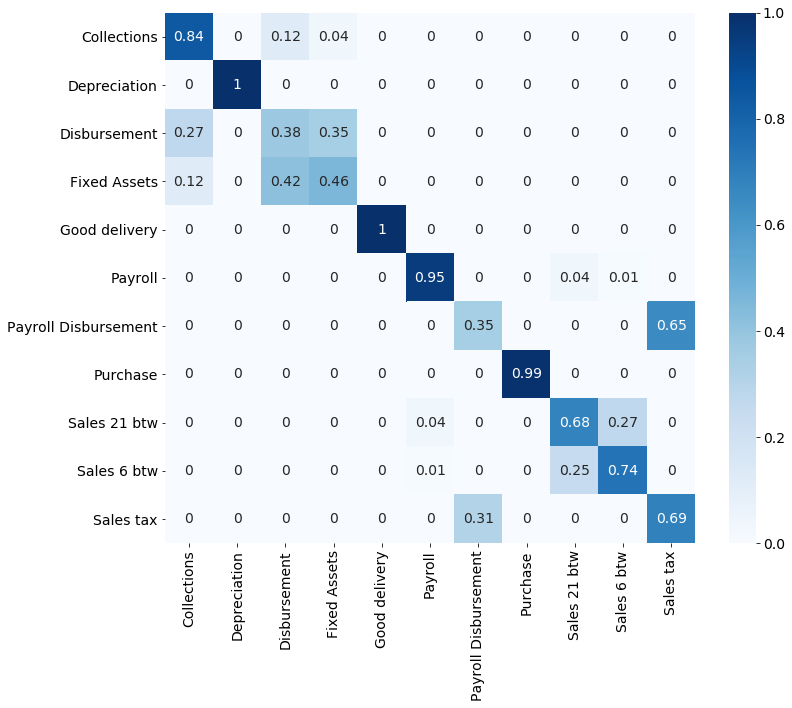

In [10]:
import seaborn as sns
set_font(14)
plt.figure(figsize=(12, 10))
sns.heatmap(final_df.apply(lambda x: round(x/x.sum(), 2), axis=1), cmap="Blues", annot=True, square=True) 
# plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("img/SensitivityAnalysis/Middle_finWalk_winSize"+str(CONFIG.WINDOW_SIZE)\
            +"_walks"+str(CONFIG.WALKS_PER_NODE)\
            +"_length"+str(CONFIG.WALKS_LENGTH) \
            +"_pressure"+str(CONFIG.PRESSURE)\
            +"_hack"+str(CONFIG.HACK)+".jpg", dpi=140, pad_inches=0.01)

## Visualisation settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *

MODE = "SimulatedData"
DB_PATH = "Simulation/FSN_Data.db"


if MODE == "SimulatedData":
    EMBS_PATH = "July5/Data2Vis_versionMetaDiff_directionCOMBI_walks20_pressure30_window2_1hopFraction0.4/TFsteps100000batch64_emb32/"
#     EMBS_PATH = "Simulation_versionMetaDiff_directionCOMBI_walks30_pressure30_window3/TFsteps100000batch64_emb32/"
    embs = pd.read_pickle(EMBS_PATH+"cache/Embeddings.pkl")
    print("Embeddings have been uploaded to memory!")
    d = upload_data(DB_PATH, limit=None)
    d = prepare_data(d)
    print("Supported information has been uploaded to memory!")

Embeddings have been uploaded to memory!
Final shape of DataFrame is  (58559, 9)
Supported information has been uploaded to memory!


In [2]:
N_CLS = 8
embs = dim_reduction(cl_Agglomerative(embs, N_CLS))

First row of Data: 
 [-0.16064171  0.13438642 -0.04356103  0.12186836  0.14403826 -0.13202798
  0.1789747  -0.16715619  0.0652208   0.19040498 -0.1197283   0.25624064
  0.17608349 -0.15397078  0.1567329   0.22998302 -0.30777571  0.03810183
  0.03599864  0.17220093  0.22173657  0.15520439 -0.21307051  0.24494869
  0.23712434 -0.09002039  0.21147229 -0.12785374  0.22915092 -0.23721875
 -0.21997549 -0.01448612]


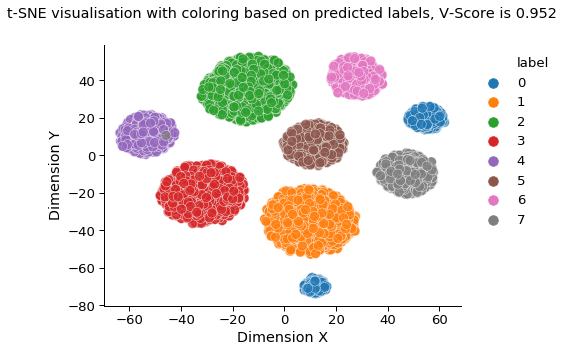

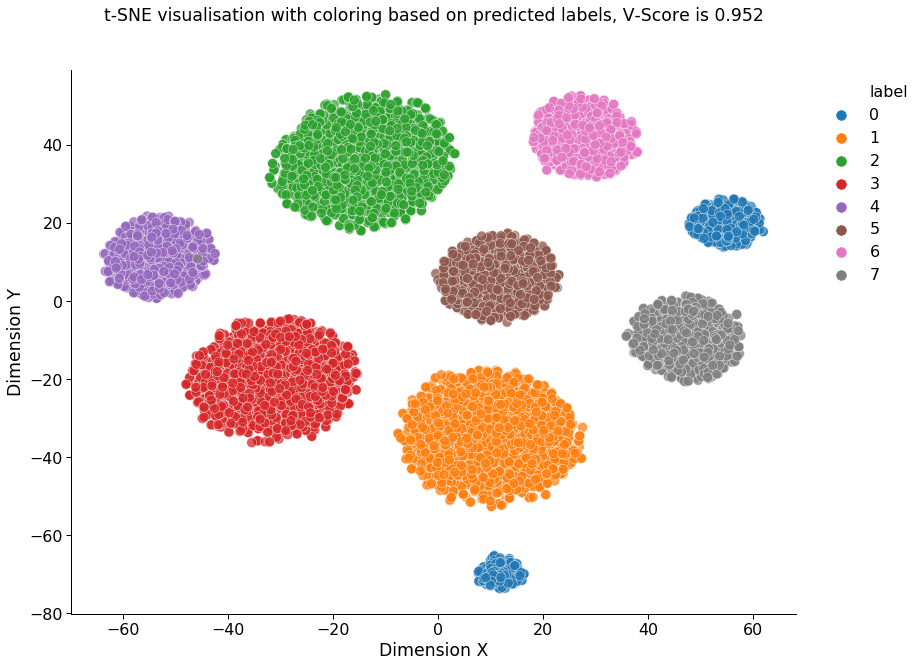

In [3]:
plot_tSNE(embs, "label", context="paper_half")
plot_tSNE(embs, "label", context="paper_full")

# Tests, July 7-8

,ExperimentNum,Strategy,Pressure,WalkPerNode,WalkLength,WindowSize,EMBD size,Train steps,Batch size,Adjusted Rand index,Adjusted Mutual Information,V-measure,Fowlkes-Mallows index,Sampling time,TF time
0,"(1, 1)",MetaDiff,10,20,8,2,32,15000,64,0.765265,0.849964,0.870989,0.793232,3.289717,10.770667
1,"(1, 2)",MetaDiff,10,20,8,2,32,15000,64,0.712172,0.836457,0.859267,0.745595,0.015551,10.908127
2,"(2, 1)",MetaDiff,10,20,8,2,32,15000,64,0.761837,0.823669,0.848486,0.789687,3.040775,9.797144
3,"(2, 2)",MetaDiff,10,20,8,2,32,15000,64,0.633905,0.812748,0.839000,0.676337,0.015313,10.340294


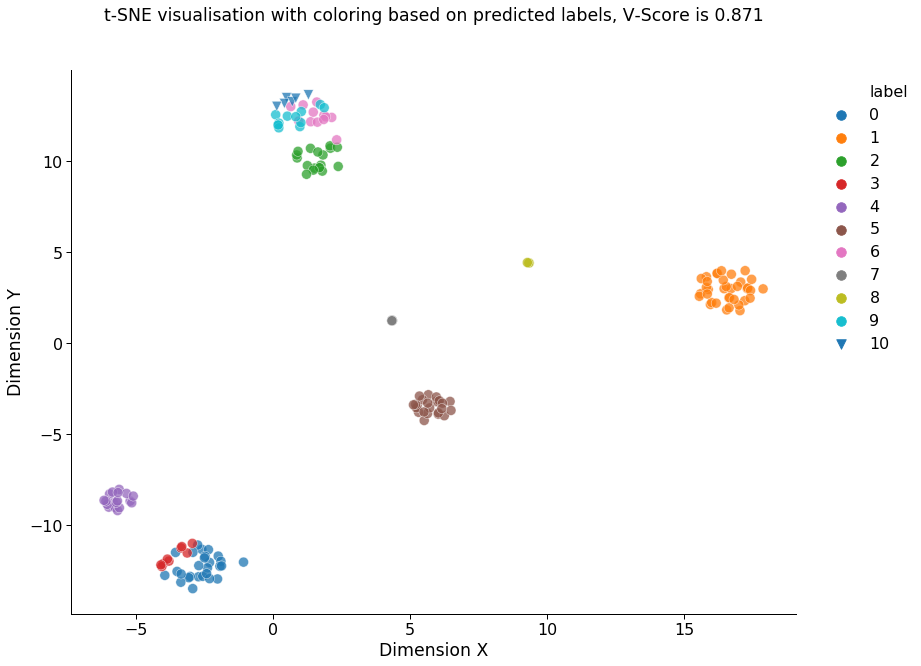

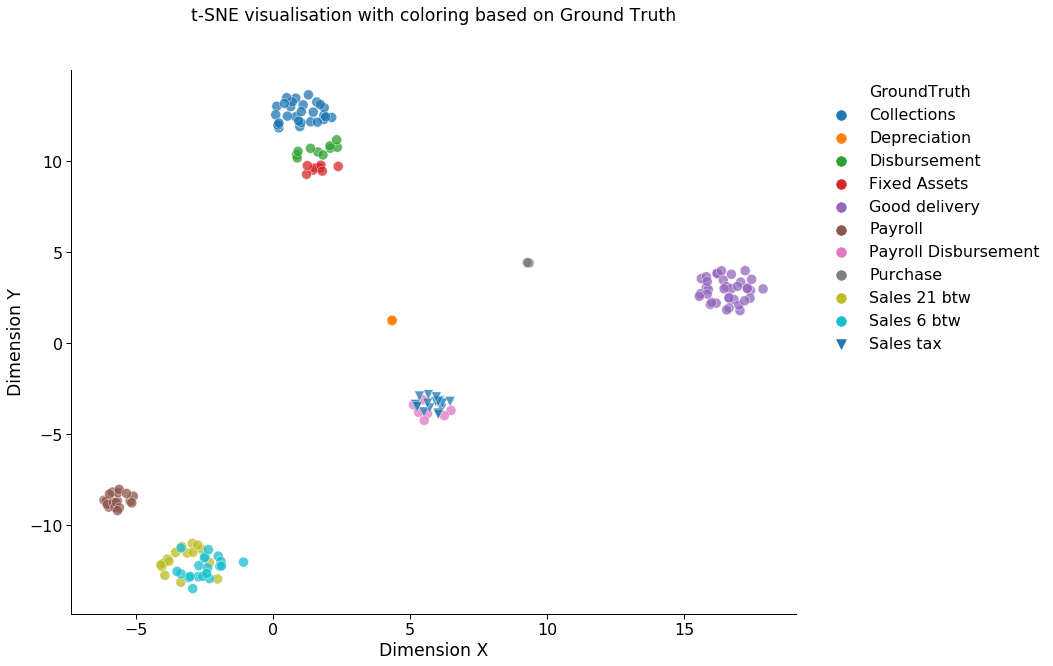

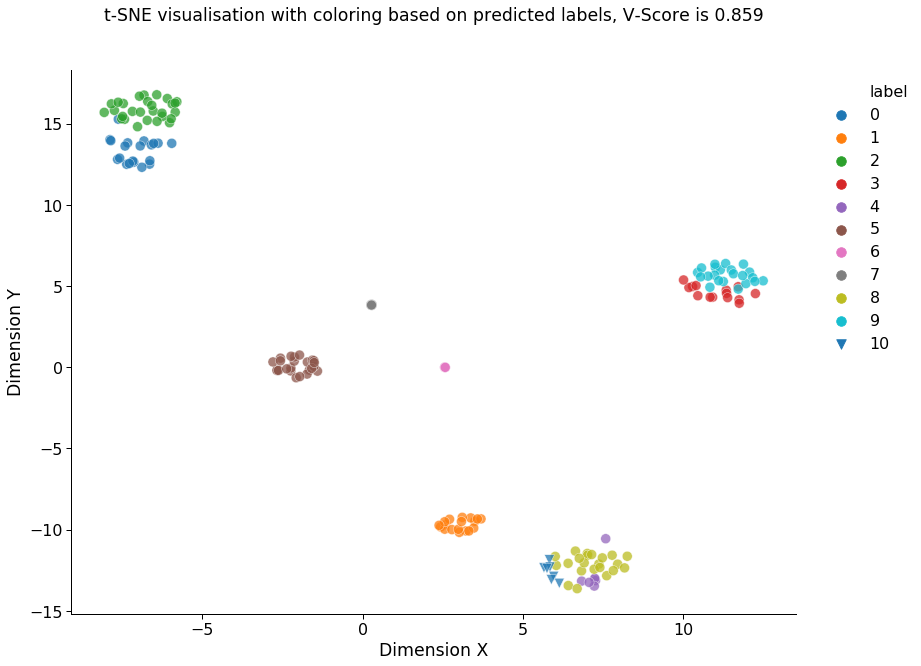

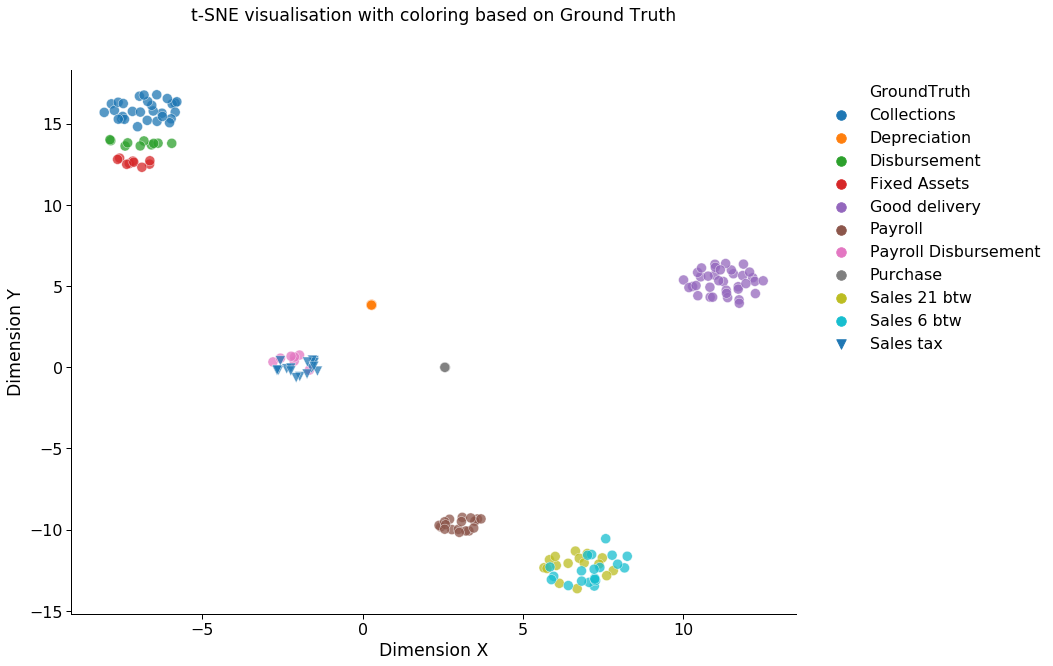

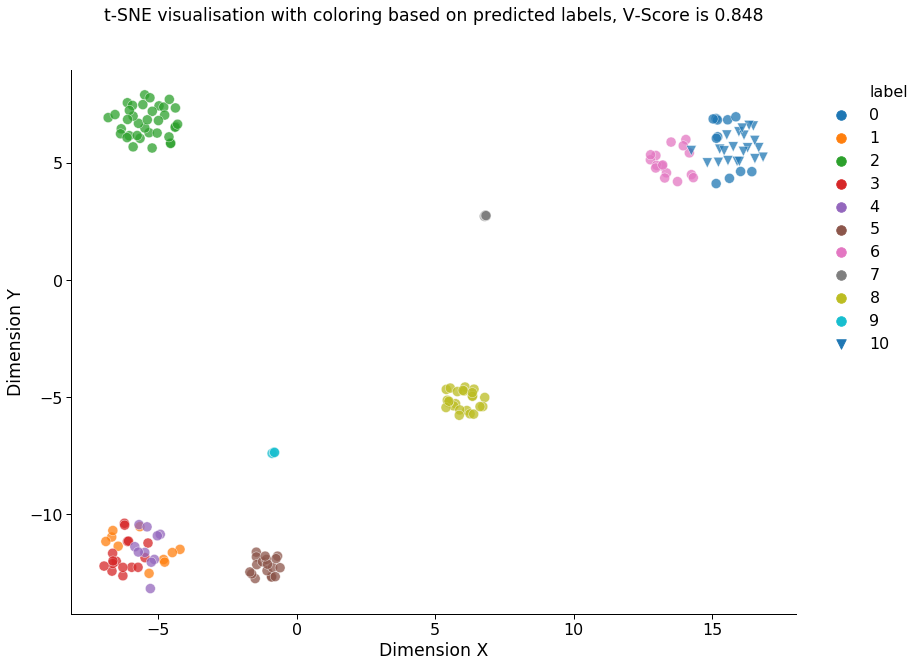

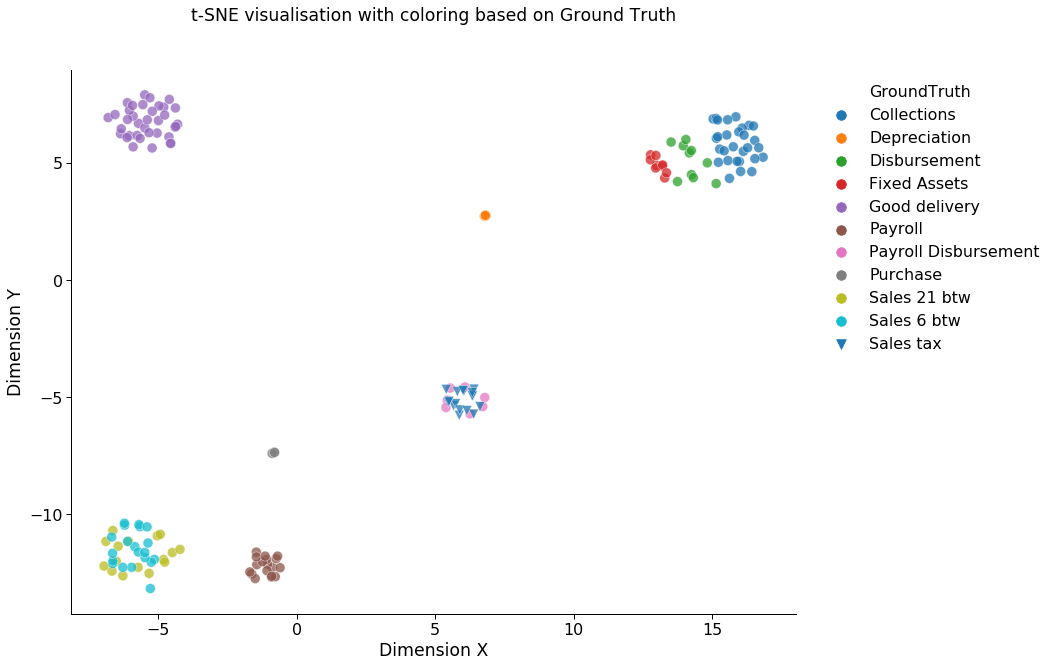

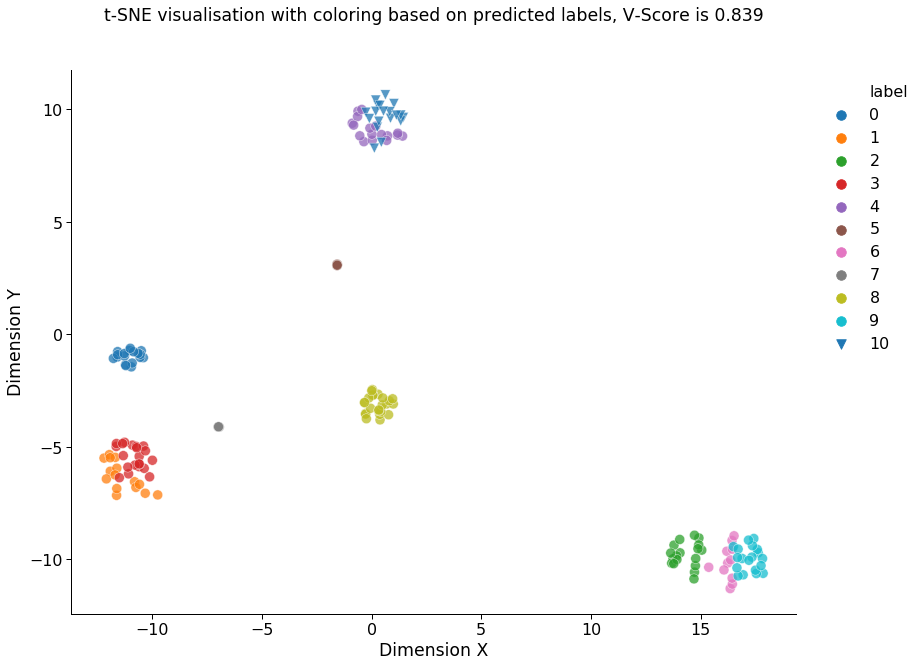

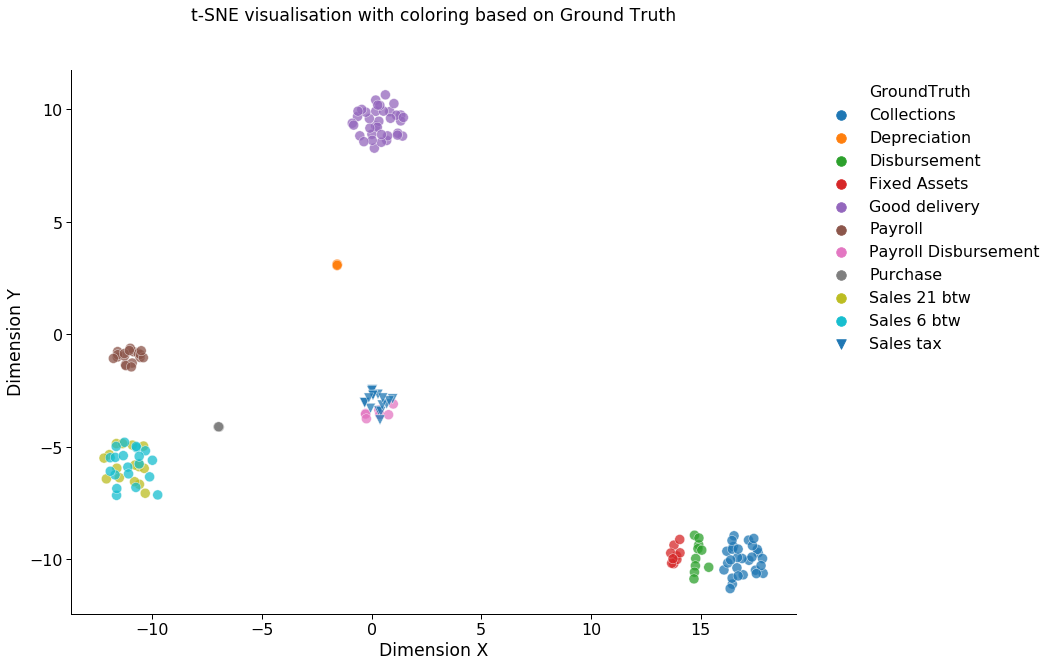

In [3]:
# encoding: utf-8
__author__ = 'Aleksei Maliutin'
"""
refactoring_experiments.py
Created by lex at 2019-07-04.
"""
from NetEmbs import *
from NetEmbs import CONFIG
from NetEmbs.utils import *
import logging
import pandas as pd
import pickle
from IPython.display import clear_output

# TODO Marcel, replace here ROOT_FOLDER to folder, where you would like to store all tmps and final Results
CONFIG.ROOT_FOLDER = "UvA/SensitivityAnalysis/"
DB_PATH = "Simulation/FSN_Data.db"
RESULT_FILE = "Results.xlsx"
LIMIT = 1000
N_CL = 11

create_folder(CONFIG.ROOT_FOLDER)

CONFIG.PRESSURE = 10
CONFIG.STEPS = 15000
# 0. Loggers adding
log_me(name=CONFIG.MAIN_LOGGER, folder=CONFIG.ROOT_FOLDER, file_name="GlobalLogs")
logging.getLogger(CONFIG.MAIN_LOGGER).info("Started..")
# 0.1 Add DataFrame to store the obtain results
try:
    # Open file with already existing results
    res = pd.read_excel(CONFIG.ROOT_FOLDER + RESULT_FILE, index_col=0)
except FileNotFoundError as e:
    # If could not find that file, create new empty one
    res = pd.DataFrame(
        columns=['ExperimentNum', 'Strategy', 'Pressure', 'WalkPerNode', 'WalkLength', 'WindowSize', 'EMBD size',
                 'Train steps', 'Batch size', 'Adjusted Rand index', 'Adjusted Mutual Information', 'V-measure',
                 'Fowlkes-Mallows index', 'Sampling time', 'TF time'])
    res.to_excel(CONFIG.ROOT_FOLDER + RESULT_FILE)
print("Welcome to refactoring experiments!")
if CONFIG.MODE == "SimulatedData":
    # 1. Upload JournaEntries into memory
    d = upload_data(DB_PATH, limit=LIMIT, logger_name=CONFIG.MAIN_LOGGER)
    journal_truth = upload_JournalEntriesTruth(DB_PATH)[["ID", "GroundTruth", "Time"]]
    # 2. Data pre-processing
    d = prepare_data(d, logger_name=CONFIG.MAIN_LOGGER)

if CONFIG.MODE == "RealData":
    # //////// TODO UPLOAD your data HERE \\\\\\\\\\
    # d = bData()
    # //////// END  \\\\\\\\\\
    d = rename_columns(d, names={"transactionID": "ID", "accountID": "FA_Name", "BR": "GroundTruth",
                                 "amount": "Value"})
    # TODO pay attention for the split argument below!
    if "Value" in list(d):
        need_split = True
    else:
        need_split = False
    d = prepare_dataMarcel(d, split=need_split, logger_name=CONFIG.MAIN_LOGGER)
    journal_truth = d.groupby("ID", as_index=False).agg({"GroundTruth": "first"})
# let's check it
countDirtyData(d, ["Debit", "Credit"])
# 3. Create Financial Statement Network object
CONFIG.GLOBAL_FSN = FSN()
CONFIG.GLOBAL_FSN.build(d, left_title="FA_Name")
print("FSN sucessfully constructed: \n", CONFIG.GLOBAL_FSN.info())
logging.getLogger(CONFIG.MAIN_LOGGER).info(f"FSN successfully constructed: \n, {str(CONFIG.GLOBAL_FSN.info())}")
for sampling_exp in [1, 2]:
    for tf_exp in [1, 2]:
        print(f'-------------- Experiment {(sampling_exp, tf_exp)} --------------')
        logging.getLogger(CONFIG.MAIN_LOGGER).info(
            f'-------------- Experiment {(sampling_exp, tf_exp)} --------------')
        CONFIG.EXPERIMENT = (sampling_exp, tf_exp)
        # 4. Update CONFIG file w.r.t. the new arguments if applicable
        try:
            updateCONFIG()
        except TypeError as e:
            logging.getLogger(CONFIG.MAIN_LOGGER).critical(e)
            raise TypeError("Critical error during CONFIG update. Stop execution!")
        except IOError as e:
            logging.getLogger(CONFIG.MAIN_LOGGER).critical(e)
            raise IOError("Critical error during CONFIG update. Stop execution!")
        cur_params = {"ExperimentNum": CONFIG.EXPERIMENT, "Strategy": CONFIG.STRATEGY,
                      "Pressure": CONFIG.PRESSURE,
                      "WalkPerNode": CONFIG.WALKS_PER_NODE,
                      "WalkLength": CONFIG.WALKS_LENGTH, "WindowSize": CONFIG.WINDOW_SIZE,
                      "EMBD size": CONFIG.EMBD_SIZE,
                      "Train steps": CONFIG.STEPS, "Batch size": CONFIG.BATCH_SIZE}
        # TODO update CONFIG values and create tmps folders
        print("Loading Embeddings from cache... wait...")
        try:
            with open(CONFIG.WORK_FOLDER[0] + CONFIG.WORK_FOLDER[1] + CONFIG.WORK_FOLDER[2] + "Embeddings.pkl",
                      "rb") as file:
                embeddings = pickle.load(file)
                run_times = {"Sampling time": 0.0, "TF time": 0.0}
        except FileNotFoundError:
            print("File not found... Recalculate \n")
            print("Sampling sequences... wait...")
            # 5.  ///////// Getting embeddings \\\\\\\\\\\\
            try:
                embeddings, run_times = get_embs_TF(evaluate_time=True)
            except Exception as e:
                logging.getLogger(CONFIG.MAIN_LOGGER).error("We've got an error in get_embs_TF function... ",
                                                            exc_info=True)

            # 6. //////// Merge with GroundTruth \\\\\\\\\
            embeddings = embeddings.merge(journal_truth, on="ID")

            # 7. Dimensionality reduction for visualisation purposes
            embeddings = dim_reduction(embeddings)
            embeddings.to_pickle(
                CONFIG.WORK_FOLDER[0] + CONFIG.WORK_FOLDER[1] + CONFIG.WORK_FOLDER[2] + "Embeddings.pkl")

        #  8.  ////////// Clustering in embedding space \\\\\\\
        cl_labs = cl_Agglomerative(embeddings, N_CL)
        # 8.1 Plot t-SNE visualisation
        plot_tSNE(cl_labs, "label", folder=CONFIG.WORK_FOLDER[0] + CONFIG.WORK_FOLDER[1] + CONFIG.WORK_FOLDER[2],
                  title="Predicted label",
                  context="paper_full")
        plot_tSNE(cl_labs, "GroundTruth",
                  folder=CONFIG.WORK_FOLDER[0] + CONFIG.WORK_FOLDER[1] + CONFIG.WORK_FOLDER[2],
                  title="Ground Truth",
                  context="paper_full")
        print("Plotted required graphs!")
        # 8.2 ////////// Evaluate clustering quality \\\\\\\
        all_metrics = evaluate_all(cl_labs)
        # 9. Construct one row with given parameters and obtained results
        cur_params.update(all_metrics)
        cur_params.update(run_times)
        # Upload previous Results file
        res = pd.read_excel(CONFIG.ROOT_FOLDER + RESULT_FILE, index_col=0)
        # Append new result to DataFrame and save as Excel file
        res = res.append(cur_params, ignore_index=True)
        res.to_excel(CONFIG.ROOT_FOLDER + RESULT_FILE)
        clear_output(wait=True)
res

In [4]:
cur_params = {"Strategy": CONFIG.STEP_VERSION,
                      "Pressure": CONFIG.PRESSURE,
                      "WalkPerNode": CONFIG.WALKS_PER_NODE,
                      "WalkLength": CONFIG.WALKS_LENGTH, "WindowSize": CONFIG.WINDOW_SIZE,
                      "EMBD size": CONFIG.EMBD_SIZE,
                      "Train steps": CONFIG.STEPS, "Batch size": CONFIG.BATCH_SIZE}
group_keys = list(cur_params.keys())
res.groupby(group_keys).mean()

,,,,,,,,Adjusted Rand index,Adjusted Mutual Information,V-measure,Fowlkes-Mallows index,Sampling time,TF time
Strategy,Pressure,WalkPerNode,WalkLength,WindowSize,EMBD size,Train steps,Batch size,,,,,,
MetaDiff,10,20,8,2,32,15000,64,0.699726,0.83642,0.85935,0.734706,1.443153,10.2089


In [1]:
myGRID = {"Strategy": ["MetaDiff"], 
          "Pressure": [1, 10, 30], 
          "Walks_Per_Node": [10, 30, 50], 
          "Window_Size": [1, 2, 3],
          "Steps": [50000, 100000],
        "Embd_Size": [16, 32, 48]}

In [4]:
myGRID = {"Strategy": ["MetaDiff"],
          "Pressure": [1, 10, 30],
          "Walks_Per_Node": [10, 30, 50],
          "Window_Size": [1, 2, 3],
          "Steps": [50000, 100000]}

In [5]:
for cur_args in get_GRID(myGRID):
    

[{'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 10,
  'WINDOW_SIZE': 1,
  'STEPS': 50000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 10,
  'WINDOW_SIZE': 1,
  'STEPS': 100000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 10,
  'WINDOW_SIZE': 2,
  'STEPS': 50000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 10,
  'WINDOW_SIZE': 2,
  'STEPS': 100000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 10,
  'WINDOW_SIZE': 3,
  'STEPS': 50000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 10,
  'WINDOW_SIZE': 3,
  'STEPS': 100000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 30,
  'WINDOW_SIZE': 1,
  'STEPS': 50000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 30,
  'WINDOW_SIZE': 1,
  'STEPS': 100000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 30,
  'WINDOW_SIZE': 2,
  'STEPS': 50000},
 {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,

In [6]:
test_args = {'STRATEGY': 'MetaDiff',
  'PRESSURE': 1,
  'WALKS_PER_NODE': 10,
  'WINDOW_SIZE': 1,
  'STEPS': 50000}

In [8]:
for key, value in test_args.items():
    setattr(CONFIG, key, value)

In [11]:
CONFIG.WINDOW_SIZE

1

In [13]:
str(test_args)

"{'STRATEGY': 'MetaDiff', 'PRESSURE': 1, 'WALKS_PER_NODE': 10, 'WINDOW_SIZE': 1, 'STEPS': 50000}"